## Setup

### Configure your API keys

To fine-tune Florence-2, you need to provide your HuggingFace Token and Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
!nvidia-smi

Mon Mar 17 14:09:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.05              Driver Version: 560.35.05      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          Off |   00000001:00:00.0 Off |                    0 |
| N/A   32C    P0             43W /  300W |       6MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### Download example data

**NOTE:** Feel free to replace our example image with your own photo.

In [2]:
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!ls -lh

total 28G
drwxr-xr-x  6 root  root 4.0K Oct 14 01:45 1
-rw-------  1 root  root 3.0K Jun  2  2024 1.json
-rw-------  1 root  root  824 Jun 30  2024 1.py
-rw-r--r--  1 root  root 1.3K Nov 10 10:40 10.py
-rw-------  1 root  root 3.6K Jun  2  2024 11.json
drwxr-xr-x  3 root  root 4.0K Nov 16 05:39 2
-rw-------  1 root  root    0 Jun 30  2024 2.poy
-rw-------  1 root  root 2.9K Jun  2  2024 4.json
-rw-------  1 root  root  17G Sep 25 08:27 A100_root_backup.tar.gz
drwxr-xr-x 11 root  root 4.0K Dec 22 08:06 AutoGPTQ
drwx------  2 root  root 4.0K Mar 30  2024 BeijingTravelGuidebook
drwxr-xr-x 16 root  root 4.0K Dec 24 14:20 BiomedParse
drwxr-xr-x  5 root  root 4.0K Mar 17 07:33 Box-versus-Wheel-auto-dataset-5
-rw-r--r--  1 root  root  188 Sep 26 02:56 Dockerfile
-rw-r-----  1 root  root 4.0M Dec 24  2018 KDE4.zh_CN-zh_TW.zh_TW
drwxr-xr-x 10 root  root 4.0K Oct 13 12:24 LLaMA-Omni
drwxr-xr-x  2 root  root 4.0K Oct 11 14:42 Llama-3.1-8B_adamw_torch
drwxr-xr-x  2 root  root 4.0K Oct 11 15:22 Lla

In [3]:
EXAMPLE_IMAGE_PATH = "dog.jpeg"

## Download and configure the model

 Let's download the model checkpoint and configure it so that you can fine-tune it later on.

In [4]:
!pip install -q transformers flash_attn timm einops peft
!pip install -q roboflow git+https://github.com/roboflow/supervision.git

In [5]:
# @title Imports

import io
import os
import re
import json
import torch
import html
import base64
import itertools

import numpy as np
import supervision as sv


from IPython.core.display import display, HTML
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from peft import LoraConfig, get_peft_model
from PIL import Image
from roboflow import Roboflow

Load the model using `AutoModelForCausalLM` and the processor using `AutoProcessor` classes from the transformers library. Note that you need to pass `trust_remote_code` as `True` since this model is not a standard transformers model.

In [6]:
CHECKPOINT = "microsoft/Florence-2-base-ft"
REVISION = 'refs/pr/6'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION).to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION)

Importing from timm.models.layers is deprecated, please import via timm.layers
Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


## Run inference with pre-trained Florence-2 model

from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


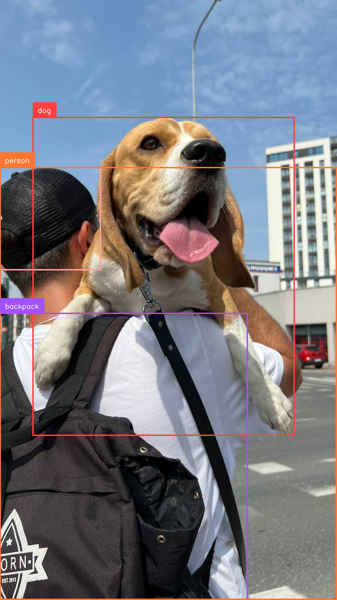

In [7]:
# @title Example object detection inference

image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<OD>"
text = "<OD>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In [8]:
detections

Detections(xyxy=array([[3.6000001e-01, 6.6879999e+02, 5.2884003e+02, 1.2780800e+03],
       [7.0920006e+01, 2.5023999e+02, 6.2892004e+02, 9.2863995e+02],
       [3.6000001e-01, 3.5775998e+02, 2.1420001e+02, 5.7535999e+02],
       [3.6000001e-01, 3.5775998e+02, 7.1892004e+02, 1.2780800e+03]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['backpack', 'dog', 'hat', 'person'], dtype='<U8')}, metadata={})

In [9]:
generated_text

'</s><s>backpack<loc_0><loc_522><loc_734><loc_998>dog<loc_98><loc_195><loc_873><loc_725>hat<loc_0><loc_279><loc_297><loc_449>person<loc_0><loc_279><loc_998><loc_998></s>'

In [10]:
# @title Example image captioning inference

image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<DETAILED_CAPTION>"
text = "<DETAILED_CAPTION>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
response

{'<DETAILED_CAPTION>': 'In this image we can see a person wearing a bag and holding a dog. In the background there are buildings, poles and sky with clouds.'}

from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


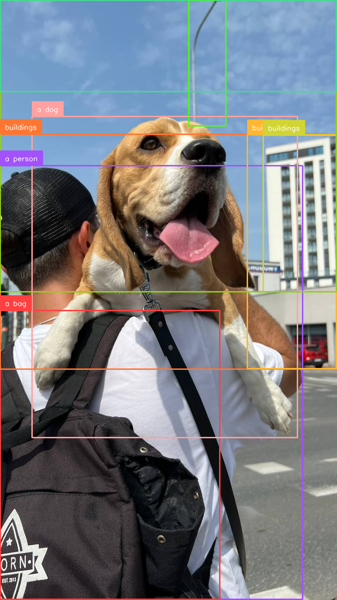

In [11]:
# @title Example caption to phrase grounding inference

image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<CAPTION_TO_PHRASE_GROUNDING>"
text = "<CAPTION_TO_PHRASE_GROUNDING> In this image we can see a person wearing a bag and holding a dog. In the background there are buildings, poles and sky with clouds."

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX) 
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In [12]:
response

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[0.36000001430511475,
    353.91998291015625,
    646.2000122070312,
    1278.0799560546875],
   [0.36000001430511475,
    662.3999633789062,
    469.08001708984375,
    1278.0799560546875],
   [68.04000091552734,
    248.95999145507812,
    635.4000244140625,
    933.7599487304688],
   [0.36000001430511475,
    286.0799865722656,
    718.9200439453125,
    787.8399658203125],
   [528.1199951171875,
    287.3599853515625,
    718.9200439453125,
    786.5599975585938],
   [562.6799926757812, 288.6399841308594, 718.9200439453125, 622.719970703125],
   [403.5600280761719,
    0.6399999856948853,
    482.760009765625,
    268.1600036621094],
   [0.36000001430511475,
    0.6399999856948853,
    718.9200439453125,
    622.719970703125],
   [0.36000001430511475,
    0.6399999856948853,
    718.2000122070312,
    195.1999969482422]],
  'labels': ['a person',
   'a bag',
   'a dog',
   'buildings',
   'buildings',
   'buildings',
   'poles',
   'sky

## Fine-tune Florence-2 on custom dataset

### Download dataset from Roboflow Universe

In [13]:
#!pip install roboflow

#from roboflow import Roboflow
ROBOFLOW_API_KEY = "m8mhuxKr9E41vmCk0CVk"
#ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("marcelo-rovai-riila").project("box-versus-wheel-auto-dataset")
version = project.version(5)
dataset = version.download("florence2-od")


loading Roboflow workspace...
loading Roboflow project...


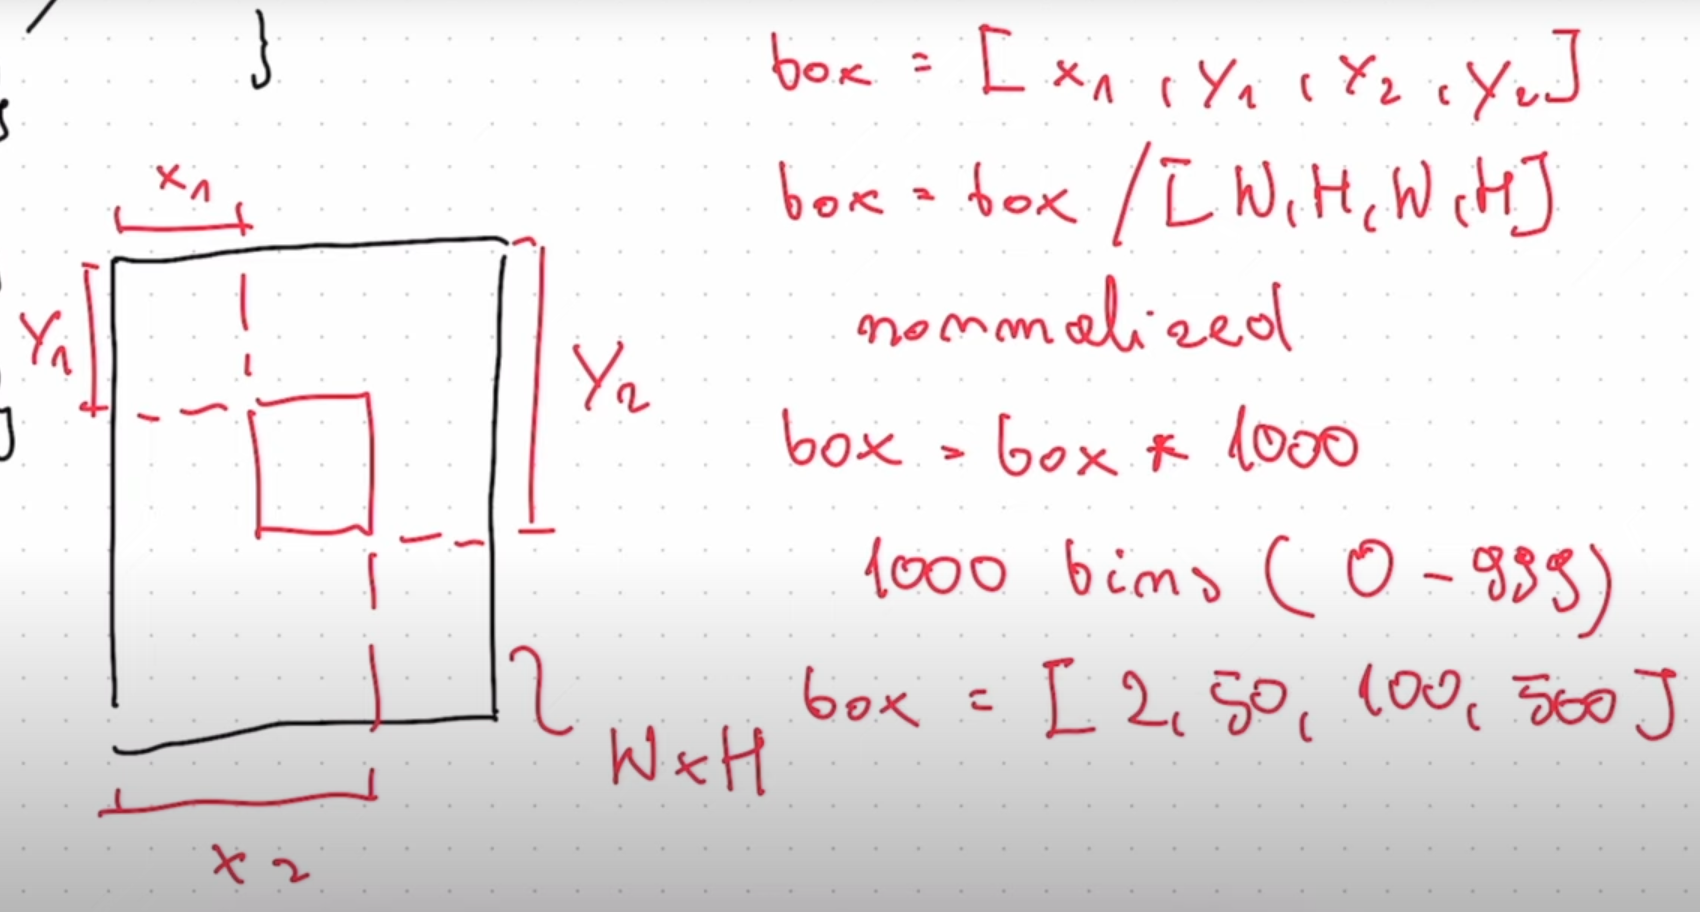

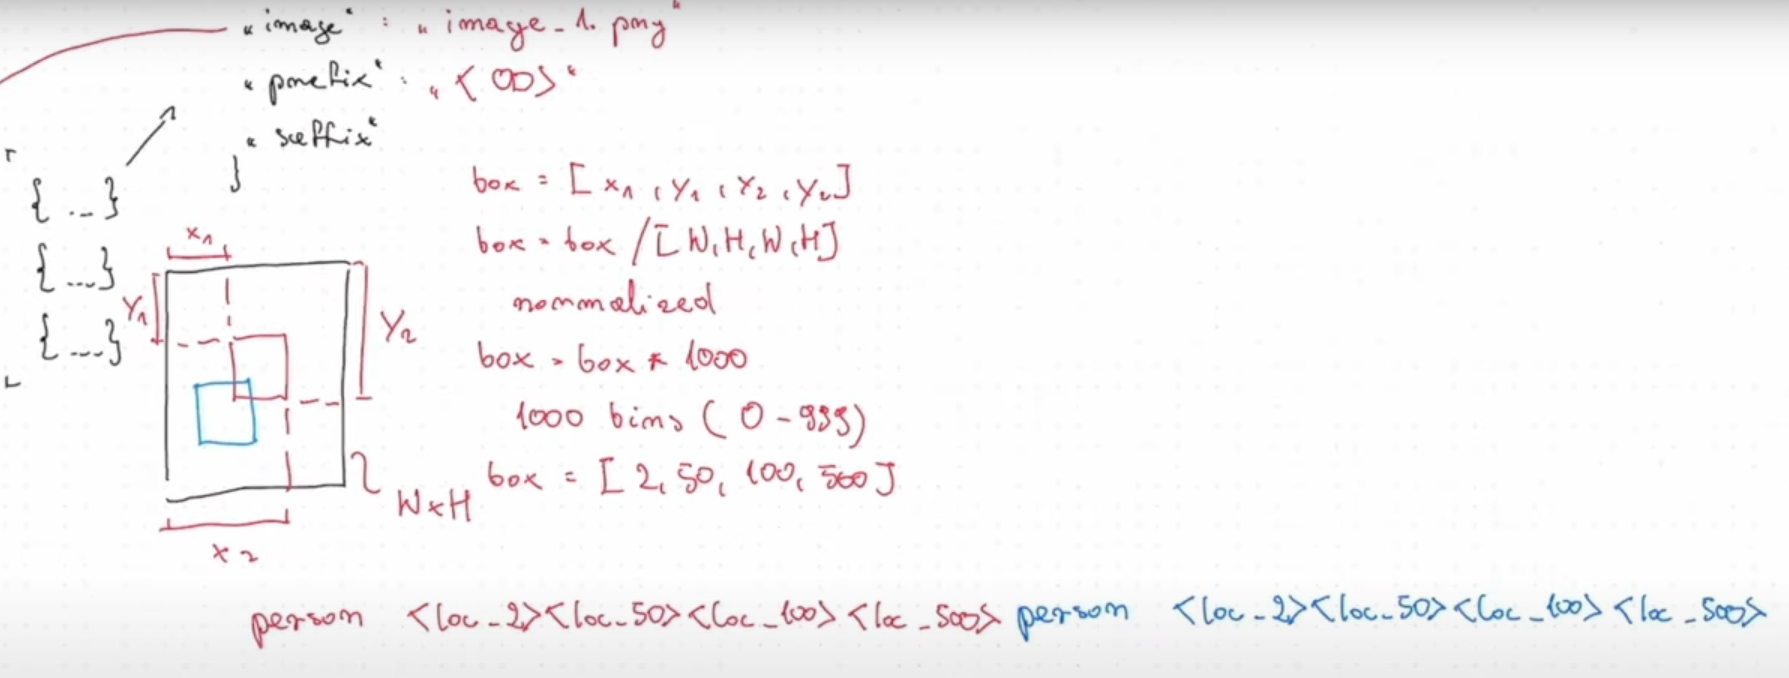

In [14]:
!head -n 5 {dataset.location}/train/annotations.jsonl

{"image":"00002_jpg.rf.04b1131fce82e470e1c8570a0168f92b.jpg","prefix":"<OD>","suffix":"box<loc_22><loc_195><loc_441><loc_783>"}
{"image":"00009_jpg.rf.1a0b27d88c6356c1ce5fac0d227bfead.jpg","prefix":"<OD>","suffix":"box<loc_195><loc_109><loc_548><loc_600>box<loc_619><loc_105><loc_938><loc_520>box<loc_503><loc_473><loc_797><loc_855>"}
{"image":"00008_jpg.rf.11d51d84c268e7dd08557ae56538f119.jpg","prefix":"<OD>","suffix":"box<loc_0><loc_84><loc_428><loc_653>box<loc_436><loc_495><loc_764><loc_945>box<loc_528><loc_84><loc_866><loc_575>"}
{"image":"00025_jpg.rf.0bd662524fd586cb98e90e4f9108043c.jpg","prefix":"<OD>","suffix":"wheel<loc_417><loc_155><loc_889><loc_714>"}
{"image":"00037_jpg.rf.075d30c88212babb2a02f2587cb85353.jpg","prefix":"<OD>","suffix":"wheel<loc_639><loc_403><loc_970><loc_819>wheel<loc_219><loc_458><loc_550><loc_886>wheel<loc_41><loc_106><loc_322><loc_431>wheel<loc_444><loc_102><loc_706><loc_427>"}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [15]:
# @title Define `DetectionsDataset` class

class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path)
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")


class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image

In [16]:
# @title Initiate `DetectionsDataset` and `DataLoader` for train and validation subsets

BATCH_SIZE = 6
NUM_WORKERS = 0

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers

train_dataset = DetectionDataset(
    jsonl_file_path = f"{dataset.location}/train/annotations.jsonl",
    image_directory_path = f"{dataset.location}/train/"
)
val_dataset = DetectionDataset(
    jsonl_file_path = f"{dataset.location}/valid/annotations.jsonl",
    image_directory_path = f"{dataset.location}/valid/"
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

In [18]:
torch.cuda.empty_cache()

trainable params: 1,929,928 || all params: 272,733,896 || trainable%: 0.7076



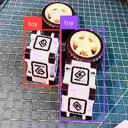
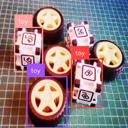
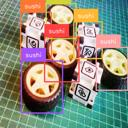
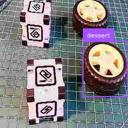

In [23]:
#!/usr/bin/env python  
# coding: utf-8  
  
"""  
示例：Florence-2 + LoRA 的推理脚本  
使用 supervision>=0.29 的新 API:  
- from_vlm(..., vlm="florence_2") 取代已弃用的 from_lmm  
- BoxAnnotator(color_lookup=sv.ColorLookup.INDEX) 等方式，避免 class_id 为空时报错  
请提前执行: pip install --upgrade supervision  
"""  
  
import io  
import os  
import json  
import base64  
import html  
import torch  
from PIL import Image  
from IPython.display import display, HTML  
from torch.utils.data import Dataset, DataLoader  
  
# 最新 supervision  
import supervision as sv  
  
# Florence-2 + LoRA  
from transformers import AutoModelForCausalLM, AutoProcessor  
from peft import LoraConfig, get_peft_model  
  
################################################################################  
# 1) 自定义 JSONLDataset 和 DetectionDataset  
################################################################################  
class JSONLDataset:  
    """  
    从 JSONL 文件中读取记录，每条格式一般是:  
    {"image": "xxx.jpg","prefix": "","suffix": "..."}  
    并从 image_directory_path 根据 "image" 找对应图像文件。  
    """  
    def __init__(self, jsonl_file_path: str, image_directory_path: str):  
        self.jsonl_file_path = jsonl_file_path  
        self.image_directory_path = image_directory_path  
        self.entries = self._load_entries()  
  
    def _load_entries(self):  
        entries = []  
        with open(self.jsonl_file_path, "r", encoding="utf-8") as file:  
            for line in file:  
                data = json.loads(line)  
                entries.append(data)  
        return entries  
  
    def __len__(self):  
        return len(self.entries)  
  
    def __getitem__(self, idx: int):  
        entry = self.entries[idx]  
        image_path = os.path.join(self.image_directory_path, entry["image"])  
        image = Image.open(image_path).convert("RGB")  
        return image, entry  
  
  
class DetectionDataset(Dataset):  
    """  
    将 JSONLDataset 包装成 torch Dataset，返回 (prefix, suffix, image) 以便后续处理。  
    """  
    def __init__(self, jsonl_file_path: str, image_directory_path: str):  
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)  
  
    def __len__(self):  
        return len(self.dataset)  
  
    def __getitem__(self, idx: int):  
        image, data = self.dataset[idx]  
        prefix = data["prefix"]  
        suffix = data.get("suffix", "")  
        return prefix, suffix, image  
  
  
################################################################################  
# 2) 加载 Florence-2 基础模型 + LoRA  
################################################################################  
CHECKPOINT = "microsoft/Florence-2-base-ft"  
REVISION = "refs/pr/6"  
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
  
# 加载基础模型及处理器  
model = AutoModelForCausalLM.from_pretrained(  
    CHECKPOINT,  
    trust_remote_code=True,  
    revision=REVISION  
).to(DEVICE)  
  
processor = AutoProcessor.from_pretrained(  
    CHECKPOINT,  
    trust_remote_code=True,  
    revision=REVISION  
)  
  
# 配置并加载 LoRA  
config = LoraConfig(  
    r=8,  
    lora_alpha=8,  
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"],  
    task_type="CAUSAL_LM",  
    lora_dropout=0.05,  
    bias="none",  
    inference_mode=False,  
    use_rslora=True,  
    init_lora_weights="gaussian",  
    revision=REVISION  
)  
  
peft_model = get_peft_model(model, config)  
peft_model.print_trainable_parameters()  
  
################################################################################  
# 3) 定义 DataLoader collate_fn  
################################################################################  
def collate_fn(batch):  
    # batch: list of (prefix, suffix, PIL.Image)  
    prefixes, suffixes, images = zip(*batch)  
    inputs = processor(  
        text=list(prefixes),  
        images=list(images),  
        return_tensors="pt",  
        padding=True  
    ).to(DEVICE)  
    return inputs, suffixes  
  
  

  
train_loader = DataLoader(  
    train_dataset,  
    batch_size=2,  
    collate_fn=collate_fn,  
    shuffle=True  
)  
  
val_loader = DataLoader(  
    val_dataset,  
    batch_size=2,  
    collate_fn=collate_fn  
)  
  
################################################################################  
# 4) 将图像转换为 HTML (base64)  
################################################################################  
def render_inline(image: Image.Image, resize=(128, 128)):  
    """  
    将 PIL Image 转为 base64 并用 HTML 内联嵌入，方便在 Jupyter/Colab 显示。  
    """  
    resized = image.resize(resize)  
    with io.BytesIO() as buffer:  
        resized.save(buffer, format='jpeg')  
        image_b64 = base64.b64encode(buffer.getvalue()).decode('utf-8')  
    return f"data:image/jpeg;base64,{image_b64}"  
  
  
################################################################################  
# 5) 核心可视化逻辑: from_vlm + BoxAnnotator + LabelAnnotator  
################################################################################  
def render_example(image: Image.Image, response: dict):  
    """  
    输入:  
        image - PIL.Image 原图  
        response - post_process_generation(...) 的返回结果，形如:  
        { "": { "bboxes": [...], "labels": [...] } }  
    输出:  
        包含渲染后图像和预测结果JSON的HTML  
    """  
    try:  
        # supervision>=0.29: 使用 from_vlm(vlm="florence_2") 解析 Florence-2 OD 输出  
        detections = sv.Detections.from_vlm(  
            vlm="florence_2",  
            result=response,  
            resolution_wh=image.size  
        )  
  
        # 此处重设 color_lookup=sv.ColorLookup.INDEX 以绕过 class_id 判定  
        box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)  
        image_annotated = box_annotator.annotate(  
            scene=image.copy(),  
            detections=detections  
        )  
  
        # 同理，给标签也按索引调色  
        label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)  
        image_annotated = label_annotator.annotate(  
            scene=image_annotated,  
            detections=detections  
        )  
    except Exception as e:  
        print("Failed to render model response:", e)  
        # 出错时直接显示原图  
        image_annotated = image  
  
    # 组装HTML  
    return f"""  
    <div style="display:inline-flex; align-items:center; margin:10px;">  
        <img width="256" height="256" src="{render_inline(image_annotated)}" />  
        <p style="font-size:small; margin-left:10px; max-width:400px;">  
            {html.escape(json.dumps(response))}  
        </p>  
    </div>  
    """  
  
  
################################################################################  
# 6) 推理 & 可视化  
################################################################################  
def render_inference_results(model, dataset: DetectionDataset, count=4):  
    """  
    对 dataset 中前 count 张图像做推理, 并渲染可视化结果到 HTML。  
    """  
    html_out = ""  
    count = min(count, len(dataset))  
  
    for i in range(count):  
        # 取图像及对应文本 (prefix, suffix)  
        image, data = dataset.dataset[i]  
        prefix = data["prefix"]  
        suffix = data.get("suffix", "")  
  
        # 构建输入  
        inputs = processor(  
            text=prefix,  
            images=image,  
            return_tensors="pt"  
        ).to(DEVICE)  
  
        # 生成模型输出(推理)  
        with torch.no_grad():  
            gen_ids = model.generate(  
                input_ids=inputs["input_ids"],  
                pixel_values=inputs["pixel_values"],  
                max_new_tokens=512,  
                num_beams=3  
            )  
        gen_text = processor.batch_decode(gen_ids, skip_special_tokens=False)[0]  
  
        # Florence-2 官方函数, 解析检测结果(必须注明 task='<OD>')  
        answer = processor.post_process_generation(  
            gen_text,  
            task='<OD>',  
            image_size=image.size  
        )  
  
        # 渲染  
        html_out += render_example(image, answer)  
  
    display(HTML(html_out))  
  
  
# 若在 Jupyter/Colab 中，可直接调用:  
render_inference_results(peft_model, val_dataset, count=4)  

## Fine-tune Florence-2 on custom object detection dataset

In [24]:
# @title Define train loop

def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    render_inference_results(peft_model, val_loader.dataset, 6)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(DEVICE)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward(), optimizer.step(), lr_scheduler.step(), optimizer.zero_grad()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    return_token_type_ids=False
                ).input_ids.to(DEVICE)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Average Validation Loss: {avg_val_loss}")

            render_inference_results(peft_model, val_loader.dataset, 6)

        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



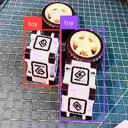
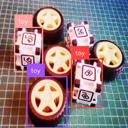
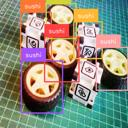
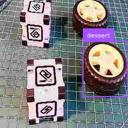
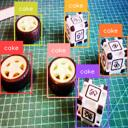
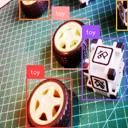

Training Epoch 1/30: 100%|██████████| 68/68 [00:18<00:00,  3.61it/s]


Average Training Loss: 6.3805049237082985


Validation Epoch 1/30: 100%|██████████| 6/6 [00:00<00:00,  7.11it/s]


Average Validation Loss: 4.9282846848169966



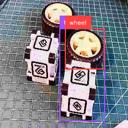
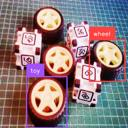
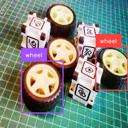
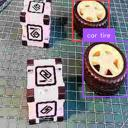
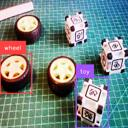
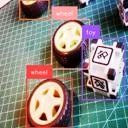

Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
Training Epoch 2/30: 100%|██████████| 68/68 [00:17<00:00,  3.80it/s]


Average Training Loss: 5.4124583146151375


Validation Epoch 2/30: 100%|██████████| 6/6 [00:00<00:00,  7.16it/s]


Average Validation Loss: 4.143871188163757



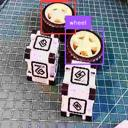
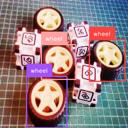
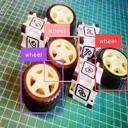
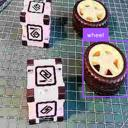
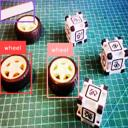
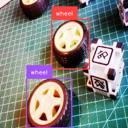

Training Epoch 3/30: 100%|██████████| 68/68 [00:17<00:00,  3.80it/s]


Average Training Loss: 4.673761166193906


Validation Epoch 3/30: 100%|██████████| 6/6 [00:00<00:00,  7.23it/s]


Average Validation Loss: 3.597840428352356



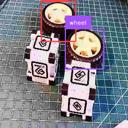
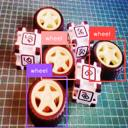
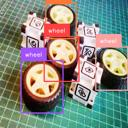
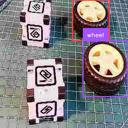
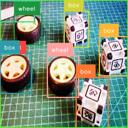
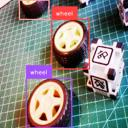

Training Epoch 4/30: 100%|██████████| 68/68 [00:17<00:00,  3.81it/s]


Average Training Loss: 4.186768651008606


Validation Epoch 4/30: 100%|██████████| 6/6 [00:00<00:00,  7.22it/s]


Average Validation Loss: 3.1255884965260825



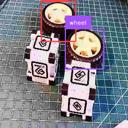
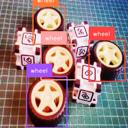
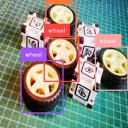
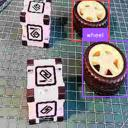
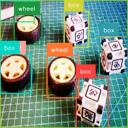
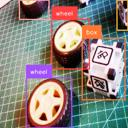

Training Epoch 5/30: 100%|██████████| 68/68 [00:17<00:00,  3.78it/s]


Average Training Loss: 3.421829069361967


Validation Epoch 5/30: 100%|██████████| 6/6 [00:00<00:00,  7.17it/s]


Average Validation Loss: 2.6929513613382974



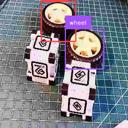
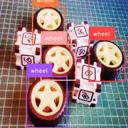
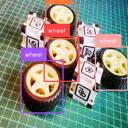
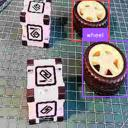
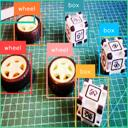
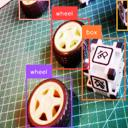

Training Epoch 6/30: 100%|██████████| 68/68 [00:18<00:00,  3.78it/s]


Average Training Loss: 3.022242225268308


Validation Epoch 6/30: 100%|██████████| 6/6 [00:00<00:00,  7.17it/s]


Average Validation Loss: 2.233963986237844



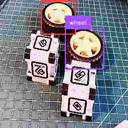
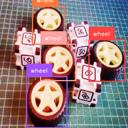
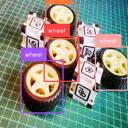
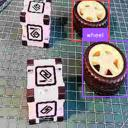
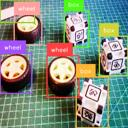
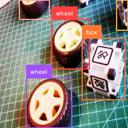

Training Epoch 7/30: 100%|██████████| 68/68 [00:18<00:00,  3.77it/s]


Average Training Loss: 2.432122181443607


Validation Epoch 7/30: 100%|██████████| 6/6 [00:00<00:00,  7.16it/s]


Average Validation Loss: 2.0321864088376365



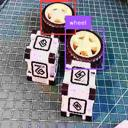
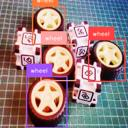
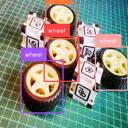
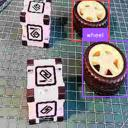
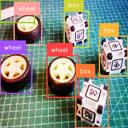
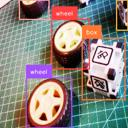

Training Epoch 8/30: 100%|██████████| 68/68 [00:18<00:00,  3.77it/s]


Average Training Loss: 2.1118145602590896


Validation Epoch 8/30: 100%|██████████| 6/6 [00:00<00:00,  7.21it/s]


Average Validation Loss: 1.9776697556177776



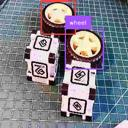
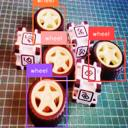
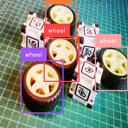
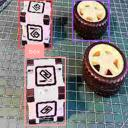
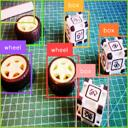
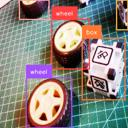

Training Epoch 9/30: 100%|██████████| 68/68 [00:17<00:00,  3.78it/s]


Average Training Loss: 2.011015269686194


Validation Epoch 9/30: 100%|██████████| 6/6 [00:00<00:00,  7.22it/s]


Average Validation Loss: 1.9480104049046834



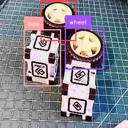
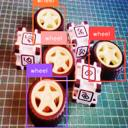
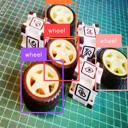
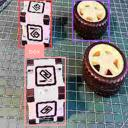
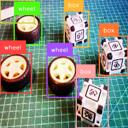
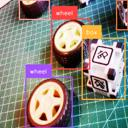

Training Epoch 10/30: 100%|██████████| 68/68 [00:17<00:00,  3.78it/s]


Average Training Loss: 1.9160912229734308


Validation Epoch 10/30: 100%|██████████| 6/6 [00:00<00:00,  7.22it/s]


Average Validation Loss: 1.9176371693611145



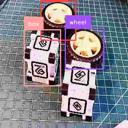
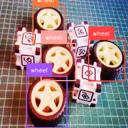
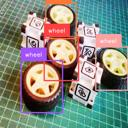
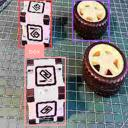
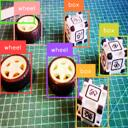
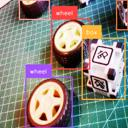

Training Epoch 11/30: 100%|██████████| 68/68 [00:18<00:00,  3.77it/s]


Average Training Loss: 1.8557747164193321


Validation Epoch 11/30: 100%|██████████| 6/6 [00:00<00:00,  7.18it/s]


Average Validation Loss: 1.9091182748476665



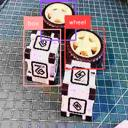
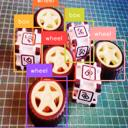
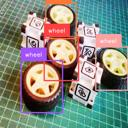
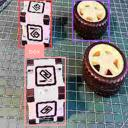
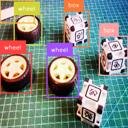
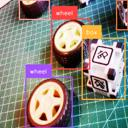

Training Epoch 12/30: 100%|██████████| 68/68 [00:18<00:00,  3.76it/s]


Average Training Loss: 1.7893022333874422


Validation Epoch 12/30: 100%|██████████| 6/6 [00:00<00:00,  7.09it/s]


Average Validation Loss: 1.8939023613929749



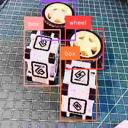
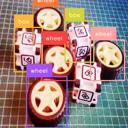
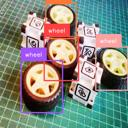
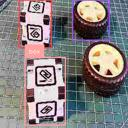
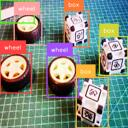
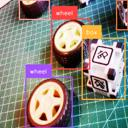

Training Epoch 13/30: 100%|██████████| 68/68 [00:18<00:00,  3.76it/s]


Average Training Loss: 1.7721149115001453


Validation Epoch 13/30: 100%|██████████| 6/6 [00:00<00:00,  7.15it/s]


Average Validation Loss: 1.8837653795878093



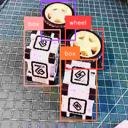
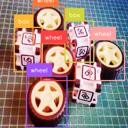
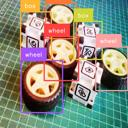
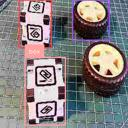
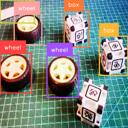
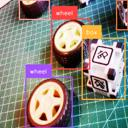

Training Epoch 14/30: 100%|██████████| 68/68 [00:18<00:00,  3.77it/s]


Average Training Loss: 1.7622298817424213


Validation Epoch 14/30: 100%|██████████| 6/6 [00:00<00:00,  7.16it/s]


Average Validation Loss: 1.8816197117169697



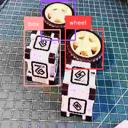
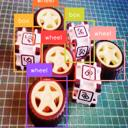
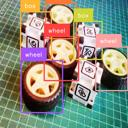
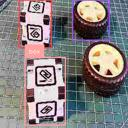
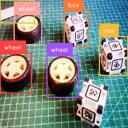
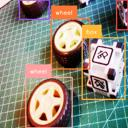

Training Epoch 15/30: 100%|██████████| 68/68 [00:18<00:00,  3.77it/s]


Average Training Loss: 1.7156349683509153


Validation Epoch 15/30: 100%|██████████| 6/6 [00:00<00:00,  7.17it/s]


Average Validation Loss: 1.8773548205693562



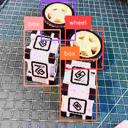
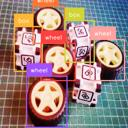
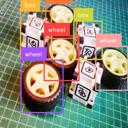
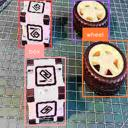
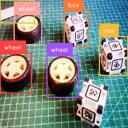
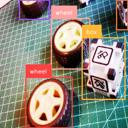

Training Epoch 16/30: 100%|██████████| 68/68 [00:18<00:00,  3.77it/s]


Average Training Loss: 1.640938120729783


Validation Epoch 16/30: 100%|██████████| 6/6 [00:00<00:00,  7.22it/s]


Average Validation Loss: 1.8690208594004314



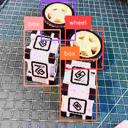
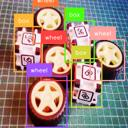
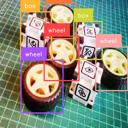
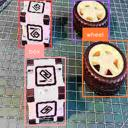
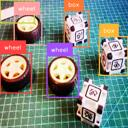
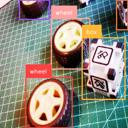

Training Epoch 17/30: 100%|██████████| 68/68 [00:18<00:00,  3.77it/s]


Average Training Loss: 1.6568998764542973


Validation Epoch 17/30: 100%|██████████| 6/6 [00:00<00:00,  7.20it/s]


Average Validation Loss: 1.8734359741210938



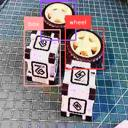
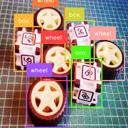
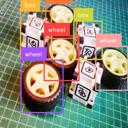
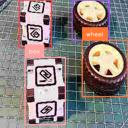
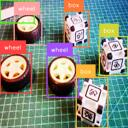
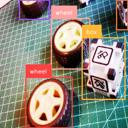

Training Epoch 18/30: 100%|██████████| 68/68 [00:18<00:00,  3.76it/s]


Average Training Loss: 1.6036186481223387


Validation Epoch 18/30: 100%|██████████| 6/6 [00:00<00:00,  7.16it/s]


Average Validation Loss: 1.8717907468477886



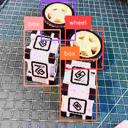
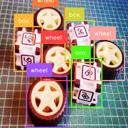
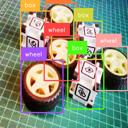
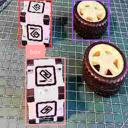
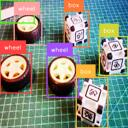
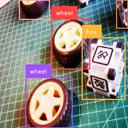

Training Epoch 19/30: 100%|██████████| 68/68 [00:17<00:00,  3.78it/s]


Average Training Loss: 1.5758805371382658


Validation Epoch 19/30: 100%|██████████| 6/6 [00:00<00:00,  7.16it/s]


Average Validation Loss: 1.8786731163660686



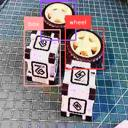
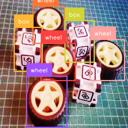
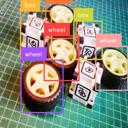
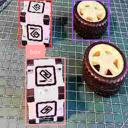
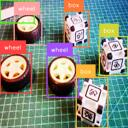
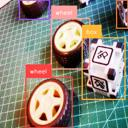

Training Epoch 20/30: 100%|██████████| 68/68 [00:17<00:00,  3.79it/s]


Average Training Loss: 1.5744008465724832


Validation Epoch 20/30: 100%|██████████| 6/6 [00:00<00:00,  7.22it/s]


Average Validation Loss: 1.876377026240031



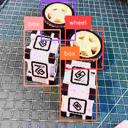
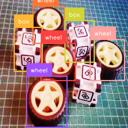
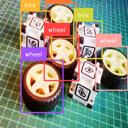
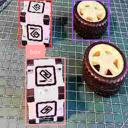
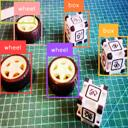
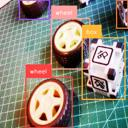

Training Epoch 21/30: 100%|██████████| 68/68 [00:18<00:00,  3.76it/s]


Average Training Loss: 1.6057569884202059


Validation Epoch 21/30: 100%|██████████| 6/6 [00:00<00:00,  7.18it/s]


Average Validation Loss: 1.8769354820251465



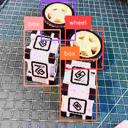
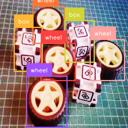
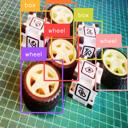
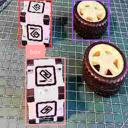
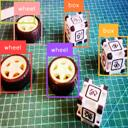
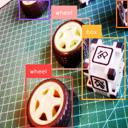

Training Epoch 22/30: 100%|██████████| 68/68 [00:17<00:00,  3.78it/s]


Average Training Loss: 1.540257817682098


Validation Epoch 22/30: 100%|██████████| 6/6 [00:00<00:00,  7.19it/s]


Average Validation Loss: 1.8748757044474285



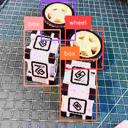
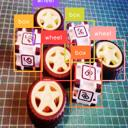
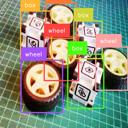
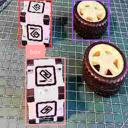
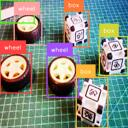
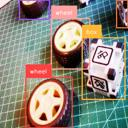

Training Epoch 23/30: 100%|██████████| 68/68 [00:17<00:00,  3.79it/s]


Average Training Loss: 1.5063799426836126


Validation Epoch 23/30: 100%|██████████| 6/6 [00:00<00:00,  7.16it/s]


Average Validation Loss: 1.874286671479543



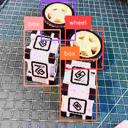
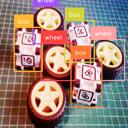
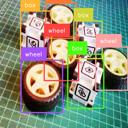
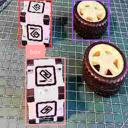
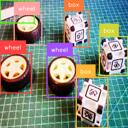
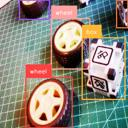

Training Epoch 24/30: 100%|██████████| 68/68 [00:18<00:00,  3.77it/s]


Average Training Loss: 1.5546682021197151


Validation Epoch 24/30: 100%|██████████| 6/6 [00:00<00:00,  7.11it/s]


Average Validation Loss: 1.8759353359540303



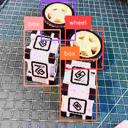
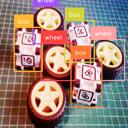
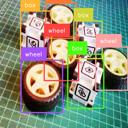
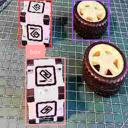
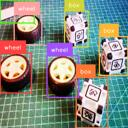
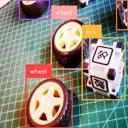

Training Epoch 25/30: 100%|██████████| 68/68 [00:18<00:00,  3.76it/s]


Average Training Loss: 1.4554413671002668


Validation Epoch 25/30: 100%|██████████| 6/6 [00:00<00:00,  7.19it/s]


Average Validation Loss: 1.8759885430335999



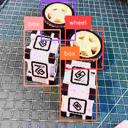
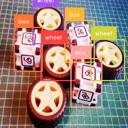
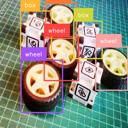
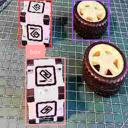
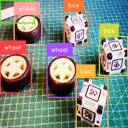
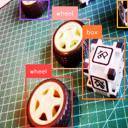

Training Epoch 26/30: 100%|██████████| 68/68 [00:18<00:00,  3.76it/s]


Average Training Loss: 1.501211611663594


Validation Epoch 26/30: 100%|██████████| 6/6 [00:00<00:00,  7.13it/s]


Average Validation Loss: 1.8755575617154439



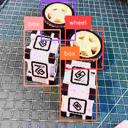
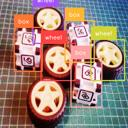
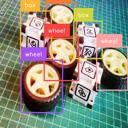
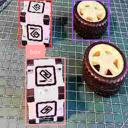
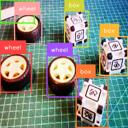
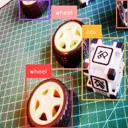

Training Epoch 27/30: 100%|██████████| 68/68 [00:18<00:00,  3.76it/s]


Average Training Loss: 1.5253541452043198


Validation Epoch 27/30: 100%|██████████| 6/6 [00:00<00:00,  7.22it/s]


Average Validation Loss: 1.877699355284373



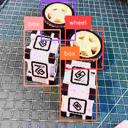
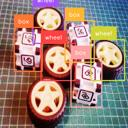
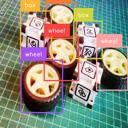
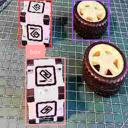
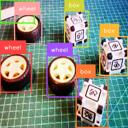
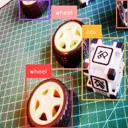

Training Epoch 28/30: 100%|██████████| 68/68 [00:18<00:00,  3.77it/s]


Average Training Loss: 1.4653552008025788


Validation Epoch 28/30: 100%|██████████| 6/6 [00:00<00:00,  7.19it/s]


Average Validation Loss: 1.8784462213516235



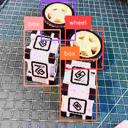
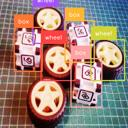
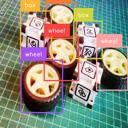
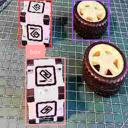
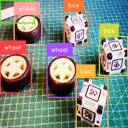
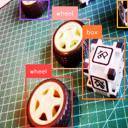

Training Epoch 29/30: 100%|██████████| 68/68 [00:18<00:00,  3.71it/s]


Average Training Loss: 1.4883572134901495


Validation Epoch 29/30: 100%|██████████| 6/6 [00:00<00:00,  6.91it/s]


Average Validation Loss: 1.878669023513794



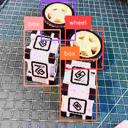
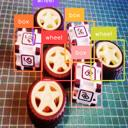
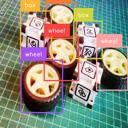
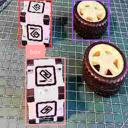
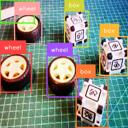
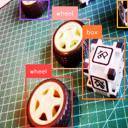

Training Epoch 30/30: 100%|██████████| 68/68 [00:18<00:00,  3.74it/s]


Average Training Loss: 1.4797345303437288


Validation Epoch 30/30: 100%|██████████| 6/6 [00:00<00:00,  7.16it/s]


Average Validation Loss: 1.8783089121182759



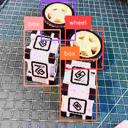
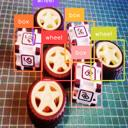
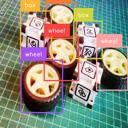
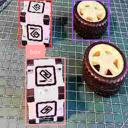
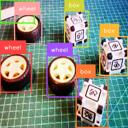
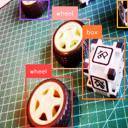

In [25]:
# @title Run train loop

#%%time

EPOCHS = 30
LR = 5e-6

train_model(train_loader, val_loader, peft_model, processor, epochs=EPOCHS, lr=LR)

## Fine-tuned model evaluation

from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


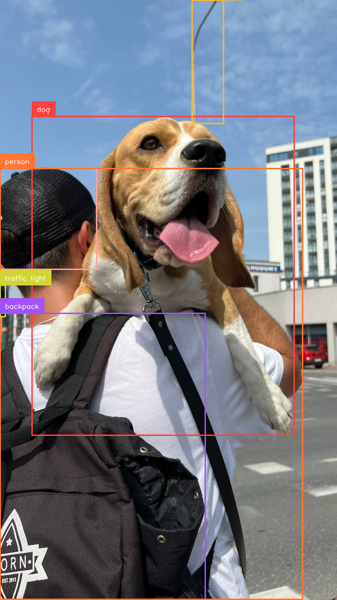

In [27]:
# @title Check if the model can still detect objects outside of the custom dataset

image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<OD>"
text = "<OD>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = peft_model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

#bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
bounding_box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX) 
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

**NOTE:** It seems that the model can still detect classes that don't belong to our custom dataset.

In [29]:
# @title Collect predictions

PATTERN = r'([a-zA-Z0-9 ]+ of [a-zA-Z0-9 ]+)<loc_\d+>'

def extract_classes(dataset: DetectionDataset):
    class_set = set()
    for i in range(len(dataset.dataset)):
        image, data = dataset.dataset[i]
        suffix = data["suffix"]
        classes = re.findall(PATTERN, suffix)
        class_set.update(classes)
    return sorted(class_set)

CLASSES = extract_classes(train_dataset)
CLASSES = ['box', 'wheel']

targets = []
predictions = []

for i in range(len(val_dataset.dataset)):
    image, data = val_dataset.dataset[i]
    prefix = data['prefix']
    suffix = data['suffix']

    inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    prediction = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
    prediction = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, prediction, resolution_wh=image.size)
    prediction = prediction[np.isin(prediction['class_name'], CLASSES)]
    prediction.class_id = np.array([CLASSES.index(class_name) for class_name in prediction['class_name']])
    prediction.confidence = np.ones(len(prediction))

    target = processor.post_process_generation(suffix, task='<OD>', image_size=image.size)
    target = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, target, resolution_wh=image.size)
    target.class_id = np.array([CLASSES.index(class_name) for class_name in target['class_name']])

    targets.append(target)
    predictions.append(prediction)

from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use 

In [30]:
# @title Calculate mAP
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.88
map50: 0.95
map75: 0.93


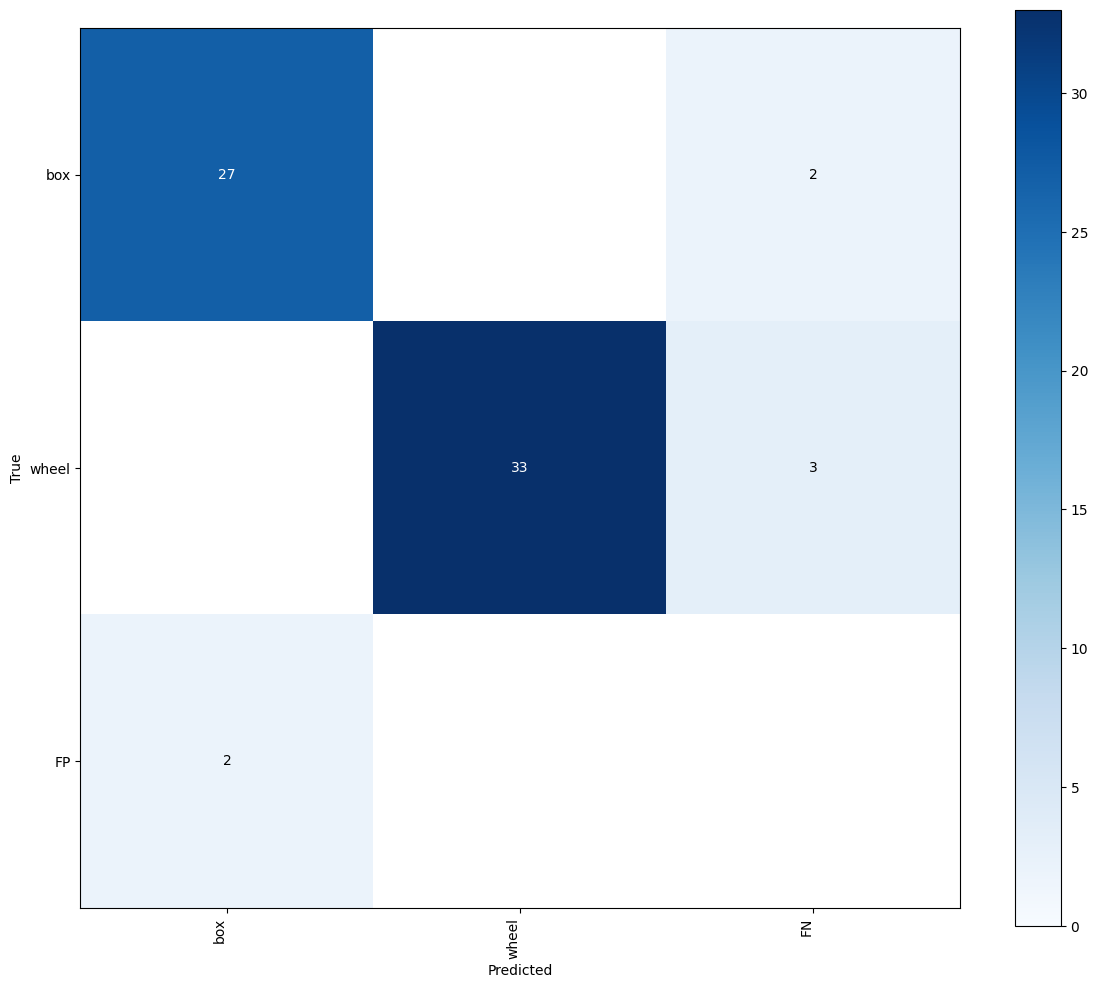

In [31]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

_ = confusion_matrix.plot()

## Save fine-tuned model on hard drive

In [ ]:
peft_model.save_pretrained("/content/florence2-lora")
processor.save_pretrained("/content/florence2-lora/")
!ls -la /content/florence2-lora/

total 12848
drwxr-xr-x 2 root root    4096 Mar 17 14:41 .
drwxr-xr-x 4 root root    4096 Mar 17 14:41 ..
-rw-r--r-- 1 root root    5102 Mar 17 14:41 README.md
-rw-r--r-- 1 root root     817 Mar 17 14:41 adapter_config.json
-rw-r--r-- 1 root root 7747264 Mar 17 14:41 adapter_model.safetensors
-rw-r--r-- 1 root root   22410 Mar 17 14:41 added_tokens.json
-rw-r--r-- 1 root root  456318 Mar 17 14:41 merges.txt
-rw-r--r-- 1 root root     633 Mar 17 14:41 preprocessor_config.json
-rw-r--r-- 1 root root  146627 Mar 17 14:41 special_tokens_map.json
-rw-r--r-- 1 root root 3747961 Mar 17 14:41 tokenizer.json
-rw-r--r-- 1 root root  197689 Mar 17 14:41 tokenizer_config.json
-rw-r--r-- 1 root root  798293 Mar 17 14:41 vocab.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [34]:
!date

Mon Mar 17 14:41:25 UTC 2025


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading base model...
Loading processor...
Loading LoRA adapter from: /content/florence2-lora

[推理] 读取图像: /var/3.png
[推理] 正在生成推理结果...
[推理] 解析检测框并可视化...
[完成] 已将检测结果保存至: result.jpg

[推理结果 JSON] =
{
  "<OD>": {
    "bboxes": [
      [
        120.86800384521484,
        120.41400146484375,
        535.1959838867188,
        529.3140258789062
      ],
      [
        0.2680000066757202,
        0.28200000524520874,
        535.1959838867188,
        563.1539916992188
      ],
      [
        0.2680000066757202,
        234.906005859375,
        535.1959838867188,
        563.1539916992188
      ],
      [
        108.54000091552734,
        52.17000198364258,
        308.468017578125,
        308.7900085449219
      ],
      [
        0.2680000066757202,
        563.718017578125,
        535.7319946289062,
        563.718017578125
      ],
      [
        238.2519989013672,
        448.6620178222656,
        330.9800109863281,
        529.8779907226562
      ],
      [
        468.19601440

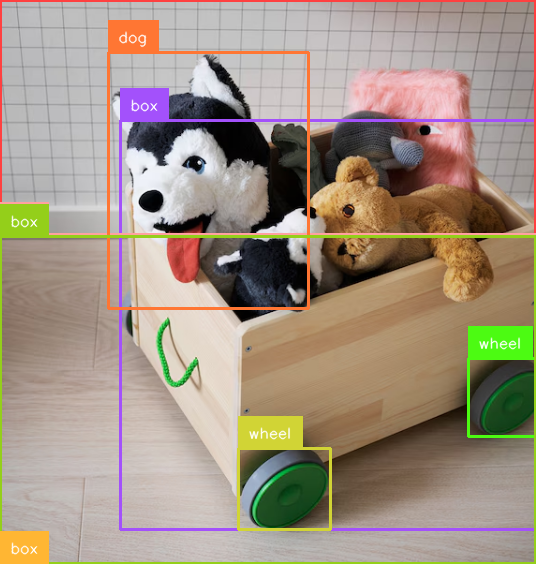

In [5]:
#!/usr/bin/env python  
# -*- coding: utf-8 -*-  
  
"""  
示例推理脚本 (可在 Jupyter 中运行):  
  1) 加载 Florence-2 的基础模型 (microsoft/Florence-2-base-ft)。  
  2) 加载微调后的 LoRA Adapter。  
  3) 读取一张图像并进行推理，可视化检测框并将结果保存到 result.jpg；  
     同时在 Jupyter 中内联输出图像。  
"""  
  
import torch  
from transformers import AutoModelForCausalLM, AutoProcessor  
from peft import PeftModel  
import supervision as sv  
from PIL import Image  
import json  
import os  
  
# 在 Jupyter 中用来显示图片  
from IPython.display import display  
  
#--------------------------#  
# 0) 环境配置/文件路径设定  
#--------------------------#  
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
  
# Florence-2 基础模型  
BASE_MODEL_NAME = "microsoft/Florence-2-base-ft"  
REVISION = "refs/pr/6"  
  
# LoRA 微调后权重的保存路径  
ADAPTER_PATH = "/content/florence2-lora"  # 示例: "/content/florence2-lora"  
  
# 测试图像的路径  
IMAGE_PATH = "/var/3.png"       # 请替换为你的图像文件路径  
  
#--------------------------#  
# 1) 加载基础模型 + Processor  
#--------------------------#  
print("Loading base model...")  
base_model = AutoModelForCausalLM.from_pretrained(  
    BASE_MODEL_NAME,  
    trust_remote_code=True,  
    revision=REVISION  
).to(DEVICE)  
  
print("Loading processor...")  
processor = AutoProcessor.from_pretrained(  
    BASE_MODEL_NAME,  
    trust_remote_code=True,  
    revision=REVISION  
)  
  
#--------------------------#  
# 2) 加载 LoRA Adapter  
#--------------------------#  
print(f"Loading LoRA adapter from: {ADAPTER_PATH}")  
peft_model = PeftModel.from_pretrained(  
    base_model,  
    ADAPTER_PATH  
).to(DEVICE)  
  
#--------------------------#  
# 3) 推理示例  
#--------------------------#  
def run_inference(image_path: str):  
    """  
    读取图像做推理，并将推理后的检测结果保存为 result.jpg 同时在 Jupyter 内联显示。  
    """  
    task = "<OD>"         # Florence-2 对目标检测的触发关键词  
    text = "<OD>"         # 推理文本提示  
  
    if not os.path.exists(image_path):  
        print(f"Error: 图像路径不存在 -> {image_path}")  
        return  
  
    print(f"\n[推理] 读取图像: {image_path}")  
    image = Image.open(image_path).convert("RGB")  
  
    # 将图像和文本打包成模型可接受的输入  
    inputs = processor(  
        text=text,  
        images=image,  
        return_tensors="pt"  
    ).to(DEVICE)  
  
    # 调用模型进行推理  
    print("[推理] 正在生成推理结果...")  
    with torch.no_grad():  
        generated_ids = peft_model.generate(  
            input_ids=inputs["input_ids"],  
            pixel_values=inputs["pixel_values"],  
            max_new_tokens=1024,  
            num_beams=3  
        )  
  
    # 解码模型输出  
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]  
  
    # 后处理: 把模型的输出(文本)转换为检测框、标签等  
    response = processor.post_process_generation(  
        generated_text,  
        task=task,  
        image_size=image.size  
    )  
  
    # 可视化检测结果  
    print("[推理] 解析检测框并可视化...")  
    detections = sv.Detections.from_vlm(  
        vlm="florence_2",  
        result=response,  
        resolution_wh=image.size  
    )  
  
    # 标注框和标签  
    box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)  
    label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)  
  
    image_annotated = box_annotator.annotate(  
        scene=image.copy(),  
        detections=detections  
    )  
    image_annotated = label_annotator.annotate(  
        scene=image_annotated,  
        detections=detections  
    )  
  
    # 保存结果到本地文件  
    output_path = "result.jpg"  
    image_annotated.save(output_path)  
    print(f"[完成] 已将检测结果保存至: {output_path}")  
  
    # 打印原始 JSON 结果 (可自行再做额外处理)  
    print("\n[推理结果 JSON] =")  
    print(json.dumps(response, indent=2, ensure_ascii=False))  
  
    # 在 Jupyter Notebook 中内联显示处理后的图  
    display(image_annotated)  
  
  
if __name__ == "__main__":  
    #--------------------------#  
    # 运行推理并打印结果  
    #--------------------------#  
    run_inference(IMAGE_PATH)  